**Table of contents**<a id='toc0_'></a>    
- [AutoML - PyCaret Quickstart](#toc1_)    
- [Regression](#toc2_)    
  - [Setting up an experiment](#toc2_1_)    
      - [Preprocessing](#toc2_1_1_1_)    
  - [Modelling](#toc2_2_)    
  - [Model diagnostics](#toc2_3_)    
  - [Model tracking](#toc2_4_)    
  - [What comes next?](#toc2_5_)    
- [Extra: Homework](#toc3_)    
- [Resources](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[AutoML - PyCaret Quickstart](#toc0_)

In [21]:
#!pip install pycaret
#!pip install markupsafe==2.0.1
#!pip install numpy==1.20
#!pip install mlflow

In [22]:
import numpy as np
import pandas as pd
import time
from sklearn.impute import KNNImputer

# <a id='toc2_'></a>[Regression](#toc0_)

In [23]:
from pycaret.regression import *

In [24]:
housing_data = pd.read_csv('https://raw.githubusercontent.com/sabinagio/data-analytics/main/data/california_housing_census.csv')
housing_data.shape

(20640, 10)

In [ ]:
# Shrink the dataset to make experiments simpler, i.e. faster to run, hopefully
housing = housing_data.copy().sample(500)
print(housing.shape)

## <a id='toc2_1_'></a>[Setting up an experiment](#toc0_)

In [41]:
# Exp with normalization, seed
exp = setup(
    housing, 
    target='median_house_value',
    normalize=True, 
    # fold=5,
    session_id=10,
    log_experiment='mlflow', 
    log_plots=True, 
    log_data=True
    )

,Description,Value
0,Session id,10
1,Target,median_house_value
2,Target type,Regression
3,Original data shape,"(500, 10)"
4,Transformed data shape,"(500, 13)"
5,Transformed train set shape,"(350, 13)"
6,Transformed test set shape,"(150, 13)"
7,Numeric features,8
8,Categorical features,1
9,Rows with missing values,1.2%


Most of this can be found in the full-on documentation: https://pycaret.readthedocs.io/en/stable/api/regression.html

#### <a id='toc2_1_1_1_'></a>[Preprocessing](#toc0_)

The cool thing about pycaret is that you can personalize a gazillion things off the bat. A couple of things that I found useful to work with:

- `ordinal_features` - which features to be encoded ordinally. By default, pycaret uses One-Hot Encoding for all categorical features. 

- `max_encoding_ohe` - when to stop doing OHE. By default, if a categorical feature has more than 25 categories, pycaret defaults to target encoding. When dealing with a regression problem, target encoding takes the mean of the target per group (only in the training set!). When dealing with a classification problem, target encoding uses the probability of an outcome happening in each of the groups.

- `ignore_features` - which features to ignore during modelling.

- `keep_features` - which features to never remove during preprocessing. **Attention:** The moel might still have other features, this option is simply there so these features can't be removed.

- `numeric_imputation`, `categorical_imputation` - to select how to fill in NaNs.

- `remove_multicollinearity`, `multicollinearity_threshold` - uses Pearson (linear) correlation to remove highly correlated variables.

- `remove_outliers`, `outliers_method` - this one doesn't remove outliers by [typical methods](https://archive.is/ruhhQ) but instead uses outlier detection algorithms such as `IsolationForest`, `EllipticEnvelope`, and `LocalOutlierFactor`

- `normalize`, `normalize_method` - how to normalize/scale the data

Other cool stuff:  

- `polynomial_features`, `polynomial_degree` - whether to create new features using the polynomials of existing features.

- `transformation`, `transformation_method` - whether to apply any transformation on the feature, in pycaret we have yeo-johnson (aka a log-transform adapted for negative values) and quantile transform (which I never used but it maps the current distribution into a to desired distribution). More easy to interpret transformations are sqrt and log transforms. There are separate options to transform the target, i.e. `transform_target` and `transform_target_method`.

- `pca`, `pca_method`, `pca_components` - whether to apply PCA for feature extraction & compression.

**Note:** While pycaret is great for doing blanket transformations over numerical/categorical variables, it starts to break down when you need a higher level of granularity, e.g. when you want to remove outliers/apply transformations only in certain columns. However, it's a great library to help you start off a project, i.e. get something up-and-running quickly.

In [33]:
# You can access directly X_train, X_test, etc.
exp.X_test  

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
6317,-117.970001,34.009998,33.0,3530.0,700.0,2959.0,679.0,3.7459,<1H OCEAN
7036,-118.080002,33.959999,35.0,2104.0,399.0,1659.0,387.0,4.0096,<1H OCEAN
9828,-121.910004,36.619999,52.0,541.0,157.0,240.0,145.0,3.5865,<1H OCEAN
605,-122.070000,37.689999,31.0,5914.0,1309.0,2999.0,1295.0,3.0964,NEAR BAY
9695,-121.610001,36.680000,37.0,3149.0,833.0,3456.0,788.0,2.8542,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
17863,-121.910004,37.419998,19.0,1684.0,387.0,1224.0,376.0,4.1389,<1H OCEAN
6821,-118.089996,34.080002,33.0,1430.0,344.0,1165.0,328.0,3.0357,<1H OCEAN
6645,-118.150002,34.169998,36.0,930.0,280.0,1024.0,300.0,1.0846,<1H OCEAN
6229,-117.940002,34.060001,32.0,3418.0,662.0,2003.0,622.0,4.0333,<1H OCEAN


In [34]:
exp.X_test_transformed

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_<1H OCEAN,ocean_proximity_NEAR OCEAN
6317,0.849920,-0.813570,0.328120,0.294735,0.325208,1.168645,0.394904,-0.062853,-0.668043,-0.388993,1.154701,-0.388993
7036,0.795565,-0.837002,0.489528,-0.207454,-0.279933,0.172914,-0.265423,0.074992,-0.668043,-0.388993,1.154701,-0.388993
9828,-1.096993,0.409596,1.861497,-0.757890,-0.766459,-0.913966,-0.812681,-0.146176,-0.668043,-0.388993,1.154701,-0.388993
605,-1.176053,0.911047,0.166712,1.134299,1.549565,1.199283,1.787923,-0.402368,-0.668043,2.570738,-0.866025,-0.388993
9695,-0.948749,0.437715,0.650936,0.160560,0.592597,1.549321,0.641396,-0.528974,-0.668043,-0.388993,1.154701,-0.388993
...,...,...,...,...,...,...,...,...,...,...,...,...
17863,-1.096993,0.784512,-0.801737,-0.355364,-0.304058,-0.160273,-0.290298,0.142581,-0.668043,-0.388993,1.154701,-0.388993
6821,0.790626,-0.780763,0.328120,-0.444814,-0.390507,-0.205464,-0.398845,-0.434098,-0.668043,-0.388993,1.154701,-0.388993
6645,0.760975,-0.738587,0.570232,-0.620897,-0.519175,-0.313463,-0.462164,-1.454001,-0.668043,-0.388993,1.154701,-0.388993
6229,0.864744,-0.790136,0.247416,0.255292,0.248812,0.436400,0.266005,0.087381,-0.668043,-0.388993,1.154701,-0.388993


In [35]:
exp.get_config('seed')

10

## <a id='toc2_2_'></a>[Modelling](#toc0_)

PyCaret is great not only because it allows you to set a crazy amount of preprocessing options but also because it allows you to compare model performance crazy easy:

In [42]:
# This might take a while to run so feel free to include only 1 model!
best_model = exp.compare_models(include=['lr', 'rf', 'xgboost', 'svm', 'knn'])

# Models included:
# lr = linear regression
# rf = random forest
# xgboost = extreme gradient boosting
# svm = support vector machine
# knn = k-nearest neighbours

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,46497.2667,4150050414.1866,63343.6260,0.6696,0.3156,0.2663,0.2990
lr,Linear Regression,53120.7210,4863336879.0511,68899.8704,0.6011,0.4068,0.3115,2.8570
knn,K Neighbors Regressor,60137.7523,6772027545.6000,81695.5828,0.4448,0.3890,0.3284,0.0740
svm,Support Vector Regression,89489.1881,13812118270.0300,116159.2217,-0.0922,0.5656,0.5314,0.0830


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

In [37]:
best_model

RandomForestRegressor(n_jobs=-1, random_state=10)

Modelling options when setting up experiments:  

- `train_size` - to decide on the size of the training set 

- `fold_strategy`, `fold` - cross-validation strategy and number of folds  

- `fold_shuffle` - random state for cross-validation

In [38]:
# By default, the cross-validation is 10-fold but we set it to 5 because of the small dataset
lr_model = exp.create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,39597.0976,3125417093.0920,55905.4299,0.6544,0.3110,0.2149
1,51074.6262,4217118786.8886,64939.3470,0.6866,0.3634,0.2907
2,55744.7218,5317760761.5020,72922.9783,0.6641,0.3351,0.2861
3,56411.0865,5869063183.1916,76609.8113,0.6684,0.4414,0.3065
4,60798.0080,5393615120.6195,73441.2358,0.6459,0.4666,0.3424
5,43082.6995,3651539204.7650,60427.9671,0.7210,0.2837,0.2435
6,42842.2079,2701555831.7550,51976.4931,0.5922,0.3101,0.3028
7,65955.6384,6875556146.9735,82918.9734,0.5515,0.5368,0.4077
8,60740.9467,7427213181.1492,86181.2809,0.2589,0.5320,0.2946


## <a id='toc2_3_'></a>[Model diagnostics](#toc0_)

On top of being able to create, optimize, and save models, pycaret also enables you to run more complex model diagnostics through the help of the `yellowbrick` library ([super useful for ML visualizations](https://www.scikit-yb.org/en/latest/)):

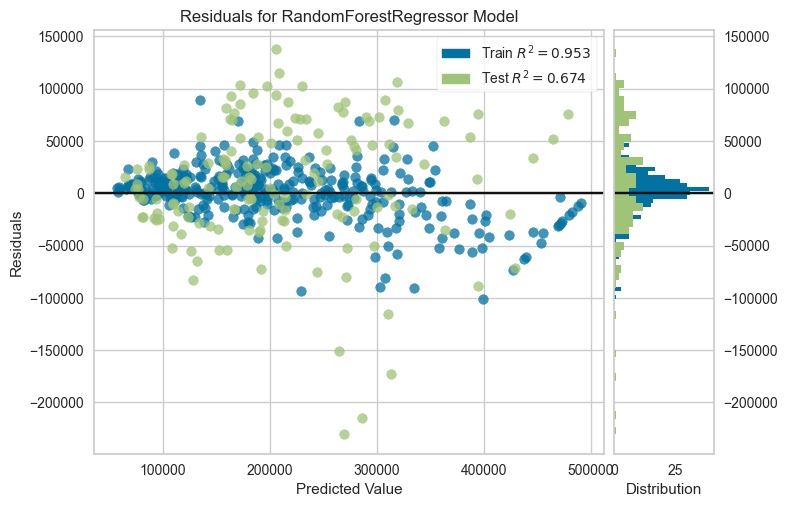

In [39]:
exp.plot_model(best_model, plot='residuals')

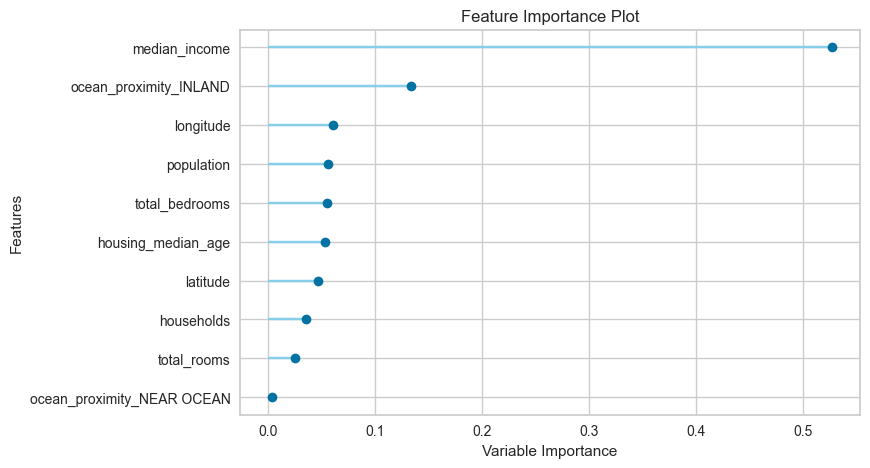

In [40]:
exp.plot_model(best_model, 'feature')

## <a id='toc2_4_'></a>[Model tracking](#toc0_)

Lastly, now that we have so much capability because of the wonderful pycaret, how are we going to keep track of all the things we've tested? Easy, pycaret is readily integrated with the most popular open-source ML-tracking software, [MLFlow](https://mlflow.org/docs/latest/index.html) - so all you need to do is to set these parameters to `True` to begin saving your results:

- `log_experiment` - if set to `True`, defaults to MLFlow, but if you want to be explicit you can also say `'mlflow'`  

- `log_data` - whether to save the train/test sets as `.csv` files  

- `log_plots` - whether to save the typical diagnostic plots

To view the results from the experiments, run this command in your terminal, in the same directory as this notebook: `mlflow ui`.

You will then see a link to the localhost, typically `http://localhost:5000`, which you can click on!

## <a id='toc2_5_'></a>[What comes next?](#toc0_)

After we evaluated all these models and picked the one that suits us the most, it's time to get it ready for production!

As we want models to see as much data as possible, we will now finally be able to re-train our model on the full sample of data!

In [44]:
X = pd.concat([exp.X_train_transformed, exp.X_test_transformed], axis=0)
y = pd.concat([exp.y_train_transformed, exp.y_test_transformed], axis=0)

In [45]:
best_model.fit(X, y)

RandomForestRegressor(n_jobs=-1, random_state=10)

In [46]:
import pickle

pickle.dump(best_model, open('best_model.pkl', 'wb'))

In [47]:
best_model = pickle.load(open('best_model.pkl', 'rb'))

In [48]:
best_model

RandomForestRegressor(n_jobs=-1, random_state=10)

# <a id='toc3_'></a>[Extra: Homework](#toc0_)

Now that we've explored the pycaret module for regression, how about you also explore the [classification module](https://pycaret.readthedocs.io/en/stable/api/classification.html)?  

Also... for those of you interested in more advanced topics, pycaret also has modules for:  
- time series
- anomaly detection, e.g. fraud prediction
- clustering 

You can find some tutorials on all modules here: https://pycaret.gitbook.io/docs/get-started/tutorials

# <a id='toc4_'></a>[Resources](#toc0_)

In [ ]:
#https://towardsdatascience.com/how-to-use-pycaret-the-library-for-lazy-data-scientists-91343f960bd2